In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))
file_path = "iot_sensor_corrupted_dataset.csv"

print("--- Información General del DataFrame ---")
df.info()

print("\n--- Primeras 5 Filas ---")
print(df.head())

print("\n--- Estadísticas Descriptivas de Columnas Numéricas ---")
print(df.describe())

--- Información General del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      260 non-null    datetime64[ns]
 1   device_id      252 non-null    object        
 2   temperature_C  247 non-null    float64       
 3   humidity_%     253 non-null    object        
 4   status         260 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 10.3+ KB

--- Primeras 5 Filas ---
            timestamp device_id  temperature_C          humidity_% status
0 2030-05-15 00:00:00  ESP32_A2      26.490142  47.391160456649544     OK
1 2023-01-01 00:30:00  ESP32_A2      24.585207   69.17861947054776     OK
2 2023-01-01 01:00:00  ESP32_B1      26.943066               -10.0     OK
3 2023-01-01 01:30:00  ESP32_B1      29.569090   70.32465260551147     OK
4 2023-01-01 02:00:00  ESP32_

<Figure size 1500x600 with 0 Axes>

In [69]:
# 1. Conversión de Columna y Asignación Directa para Evitar Advertencias
df_clean.loc[:, 'temperature_C'] = pd.to_numeric(df_clean['temperature_C'], errors='coerce')
df_clean.loc[:, 'humidity_%'] = pd.to_numeric(df_clean['humidity_%'], errors='coerce')

# Definición de rangos 
TEMP_MIN, TEMP_MAX = 10.0, 40.0
HUM_MIN, HUM_MAX = 0.0, 100.0

# Contar cuántos datos están fuera de los límites definidos
temp_outliers_count = df_clean[(df_clean['temperature_C'].notna()) & ((df_clean['temperature_C'] < TEMP_MIN) | (df_clean['temperature_C'] > TEMP_MAX))].shape[0]
hum_outliers_count = df_clean[(df_clean['humidity_%'].notna()) & ((df_clean['humidity_%'] < HUM_MIN) | (df_clean['humidity_%'] > HUM_MAX))].shape[0]

print(f"\n--- Anomalías de Valores Imposibles (Outliers Físicos) ---")
print(f"Temperatura (Fuera de {TEMP_MIN}°C - {TEMP_MAX}°C): {temp_outliers_count} registros.")
print(f"Humedad (Fuera de {HUM_MIN}% - {HUM_MAX}%): {hum_outliers_count} registros.")


--- Anomalías de Valores Imposibles (Outliers Físicos) ---
Temperatura (Fuera de 10.0°C - 40.0°C): 9 registros.
Humedad (Fuera de 0.0% - 100.0%): 9 registros.


In [70]:
print("\n--- Valores Faltantes (NaN) ---")
missing_data = df_clean.isnull().sum()
print(missing_data[missing_data > 0])


--- Valores Faltantes (NaN) ---
device_id         8
temperature_C    12
humidity_%       12
dtype: int64


In [71]:
print("\n--- Anomalías de Estado del Sensor ---")
status_counts = df_clean['status'].value_counts(dropna=False)
print("Distribución de 'status':")
print(status_counts)


--- Anomalías de Estado del Sensor ---
Distribución de 'status':
status
OK       185
FAIL      52
ok         5
FAIL       5
Ok         5
Name: count, dtype: int64


In [72]:
# Filtrar y Limpiar por Año
df_valid_time = df_clean[df_clean['timestamp'].dt.year == 2023].dropna(subset=['timestamp'])


In [73]:
# Crear columna de error_total
df_valid_time['data_quality_issue'] = (
    df_valid_time['status'].eq('FAIL') |                      # Falla de sensor reportada
    df_valid_time['temperature_C'].isnull() |                 # Temp NaN
    df_valid_time['humidity_%'].isnull() |                    # Humedad NaN
    (df_valid_time['temperature_C'] < TEMP_MIN) |
    (df_valid_time['temperature_C'] > TEMP_MAX) |
    (df_valid_time['humidity_%'] < HUM_MIN) |
    (df_valid_time['humidity_%'] > HUM_MAX)
)

quality_by_device = df_valid_time.groupby('device_id')['data_quality_issue'].agg(['sum', 'count'])
quality_by_device['error_rate'] = (quality_by_device['sum'] / quality_by_device['count']) * 100


In [74]:
print("\n--- Tasa de Error de Calidad de Datos por Dispositivo (2023) ---")
print(quality_by_device.sort_values(by='error_rate', ascending=False))


--- Tasa de Error de Calidad de Datos por Dispositivo (2023) ---
                sum  count  error_rate
device_id                             
ESP32_A1         33     81   40.740741
ESP32_A2         26     75   34.666667
ESP32_B1         19     74   25.675676
unknown_device    1      5   20.000000


In [75]:
# El DataFrame df_valid_values contiene todos los datos limpios y válidos.
valid_records_count = df_valid_values.shape[0]
total_records_initial = df.shape[0]
invalid_records_count = total_records_initial - valid_records_count

print("--- Resumen de Datos Válidos/Inválidos ---")
print(f"Total de Registros Iniciales: {total_records_initial}")
print(f"Registros Considerados Válidos: {valid_records_count}")
print(f"Registros Inválidos (a corregir/eliminar): {invalid_records_count}")
print(f"Porcentaje de Pérdida/Error: {(invalid_records_count / total_records_initial) * 100:.2f}%")


--- Resumen de Datos Válidos/Inválidos ---
Total de Registros Iniciales: 260
Registros Considerados Válidos: 206
Registros Inválidos (a corregir/eliminar): 54
Porcentaje de Pérdida/Error: 20.77%


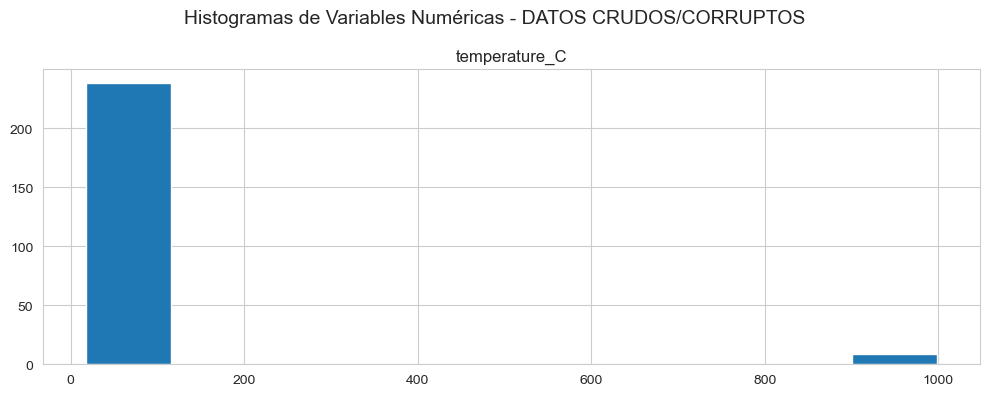

In [76]:
df[numeric_cols].hist(figsize=(10, 4))
plt.suptitle("Histogramas de Variables Numéricas - DATOS CRUDOS/CORRUPTOS", fontsize=14)
plt.tight_layout()
plt.show()

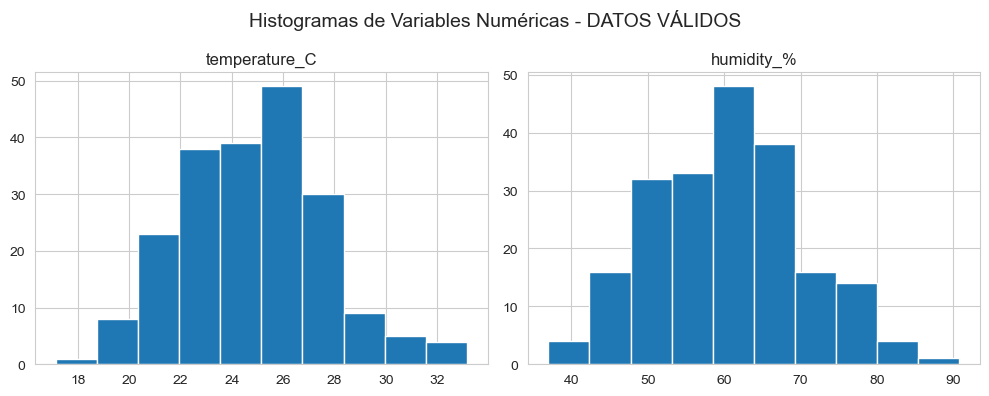

In [77]:
df_valid_values[numeric_cols].hist(figsize=(10, 4))
plt.suptitle("Histogramas de Variables Numéricas - DATOS VÁLIDOS", fontsize=14)
plt.tight_layout()
plt.show()

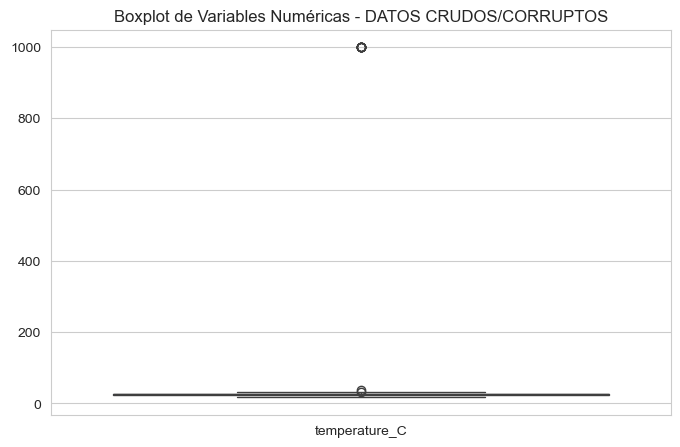

In [78]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot de Variables Numéricas - DATOS CRUDOS/CORRUPTOS")
plt.show()

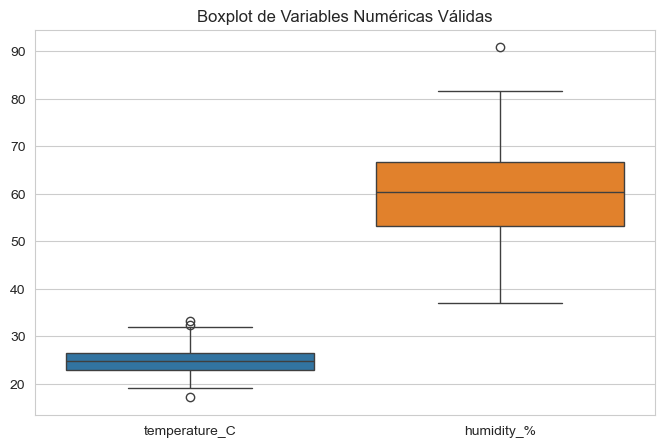

In [79]:
# Columnas numéricas a graficar
numeric_cols = ['temperature_C', 'humidity_%']

# Gráfico de Boxplots (Básico)
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_valid_values[numeric_cols])
plt.title("Boxplot de Variables Numéricas Válidas")
plt.show()